# Test the two-line CLEDB inversion on synthetic data.

In [1]:
## the script version "test_2line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

In [1]:
## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams
params=ctrlparams.ctrlparams()    ##Initialize and use a shorter label

## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).
import numpy as np           ## Defines variables to store/load headers

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 observation arrays



### 1. Import the synthetic CLE observation.

In [2]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
#     sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
# ### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]

# ## A fake minimal header for CLE
# ## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun. The wavelength raferences (vacuum), ranges and spectral resolutions are unique. See CLE outfiles and grid.dat.
# head_in =  [np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
#                      -0.75, 0.8, 1074.62686-0.0124,\
#                      (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0247,"CLE-SIM"),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
#             np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
#                      -0.75, 0.8, 1079.78047-0.0124,\
#                      (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0249,"CLE-SIM"),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume', 'U7')]).view(np.recarray)  ]

# 
#waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
#waveB=waveB[::-1]

In [3]:
## observations of sheetlos coronal structure of a Fe XIII combined observation
## sobsa is the combined 5 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_sheetslos_hires_fullspectra.pkl','rb') as f:
#    sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]


# waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
# waveB=waveB[::-1]

In [4]:
## load the fake observation muram data.             
## FE XIII 1074+1079

with open('obsstokes_avg_muram3.pkl','rb') as f:
    sobsa = pickle.load(f) 
sobsa=sobsa[0]  

## A fake minimal header for MURAM
## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun (from muram xvec and yvec arrays). The wavelength raferences (vacuum), ranges and spectral resolutions are unique (muram wvvec1 and wvvce2 arrays).
head_in =  [np.array((0, 0, 0,\
                     -0.071, 0.989, 1074.257137,\
                     0.0001379,  0.0000689, 0.0071641,"MUR-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
            np.array((0, 0, 0,\
                    -0.071, 0.989, 1079.420513,\
                     0.0001379,  0.0000689, 0.0071985,"MUR-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray)  ]

## muram data too big to include as test data!!!!

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [5]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [6]:
## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]  ## standard python lists will be deprecated ; they do not work well with numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None, None]

##### preprocess the observation "files"

In [7]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,head_in,params)

------------------------------------
--------OBS PROCESSING START--------
------------------------------------
We are inverting observations of 2 coronal line(s) 
Line 1: Fe XIII 1074.7nm
Line 2: Fe XIII 1079.8nm
------------------------------------
-----OBS PREPROCESS FINALIZED-------
------------------------------------


In [8]:
## select and pre-read the database files based on the observation preprocessing
## At this point, the database should be generated and properly linked.
importlib.reload(prepinv)       ## If module is modified, reload the contents
db_enc,database,dbhdr=prepinv.sdb_preprocess(yobs,keyvals,params)
## Warning, this might be memory consuming; see details in documentation

------------------------------------
----------DB READ START-------------
------------------------------------
CLEDB covers a span of 51 heights between 1.0 - 1.5 Solar radius
Load DB datafiles for 7  heights in memory for 2 line(s).
------------------------------------
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0000.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0000.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0060.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0060.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1074/DB0050.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_1079/DB0050.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/db204_R0500/fe-xiii_107

##### At this point all necesary data and required databases are loaded into memory for fast processing

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [9]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [ ]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)      ## when storing to disk do an if to reduce dimensions for 1 line cases

##### Process the LOS magnetic fields from the first line

In [12]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)

--------------------------------------
---BLOS_PROC: LOS B ESTIMATION START--
--------------------------------------
--------------------------------------
---BLOS_PROC: LOS B ESTIMATION END----
--------------------------------------


##### Process the full vector magnetic field inversion products

In [ ]:
importlib.reload(procinv)       ## If module is modified, reload the contents
sobs_dopp=np.zeros((600,280,3))
invout,sfound=procinv.cledb_invproc(sobs_totrot,sobs_dopp,database,db_enc,yobs,aobs,rms,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.iqud,params.reduced,params.verbose)
## WARNING: This step has a significantly long execution time.

--------------------------------------
CLEDB_IVPROC: TWO LINE INVERSION START
--------------------------------------
CLEDB_INVPROC (IQUV): Executing ext. loop: 0  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 1  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 2  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 3  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 4  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 5  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 6  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 7  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 8  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing ext. loop: 9  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC (IQUV): Executing e

## All should be good if we reached this point; all the outputs should be computed and saved in memory.

## 4. OPTIONAL tidbits

In [18]:
##optionally needed libraries and functions

from datetime import datetime
import os
import glob
import numpy as np

from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if widget is installed
##%matplotlib widget       

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.3f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar



### 4.a DUMP results (optional)

In [19]:
## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_2line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])
        
## save the last run 
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")        
specout=0
blosout=0
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')

if os.path.isfile(f"testrun_outputs/outparams_2line_{datestamp}.pkl"):
    print("Save data exists; Are you sure you want to overwrite?")
else:
    with open(f'./testrun_outputs/outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([specout,blosout,invout,sfound], f)

### 4.b PLOT the outputs (optional)

In [20]:
## Plot utils

linen=0               ## choose which line to plot; range is [0:1] for 2 line input

## plot subranges for soome in snapshots
## 3dipole
# srx1=230
# srx2=400
# sry1=65
# sry2=195
# rnge=[0.8,1.5,-1.1,1.1]

# #muram      ## muram data not offered as part of the test scripts due to large sizes.
srx1=0
srx2=1023
sry1=0
sry2=1023
rnge=[0.989,1.060,-0.071,0.071]


In [ ]:
##Plot spectroscopy

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,10))

## remove the 0 values and unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='bone')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting    
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################

ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds')
plots[1,0].set_title('Stokes I int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,1].set_title('Stokes Q int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,2].set_title('Stokes U int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,6])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,6])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,3].set_title('Stokes V int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8] >= 0.50 )
vvmax=np.max(mx)
ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,vmin=0.0,vmax=vvmax,cmap='YlGnBu')
plots[2,0].set_title('Line full width half max.')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values from plotting range.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS above.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9] >= 0.50 )
vvmax=np.nanmax(mx)
ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,vmin=0.0,vmax=vvmax,cmap='YlGnBu')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,10], mask=specout[srx1:srx2,sry1:sry2,linen,10] >= 0.050 )
vvmax=np.nanmax(mx)
ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,vmin=0.0,vmax=vvmax,cmap='YlOrRd')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values from plotting range.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,11], mask=specout[srx1:srx2,sry1:sry2,linen,11] >= 0.050 )
vvmax=np.nanmax(mx)
ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,vmin=0.0,vmax=vvmax,cmap='YlOrRd')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################

plt.tight_layout()
### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/specout_1line_line{linen}_{datestamp}.pdf")

In [18]:
print( specout[500,500,0,3:8])
print(sobs_tot[500,500,:])
print(rms[500,500,:])

[1.33213989e+03 1.39976180e+00 3.83103698e-01 1.22749805e-01
 1.17717047e+01]
[2.8084229e+04 2.8972872e+01 8.1299820e+00 3.6037304e+00 2.4112943e+04
 2.2103262e+00 6.1046076e-01 3.1447189e+00]
[0.00017277 0.00012217 0.00012217 0.00012217 0.00016102 0.00012217
 0.00012217 0.00012217]


In [ ]:
## plot 1-line BLOS
linen=0

fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ab=plots[0,0].imshow(blosout[srx1:srx2,sry1:sry2,0,linen],extent=rnge,cmap='seismic',vmin=-120,vmax=120)
plots[0,0].set_title('1$^{st}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')

ab=plots[0,1].imshow(blosout[srx1:srx2,sry1:sry2,1,linen],extent=rnge,cmap='seismic',vmin=-120,vmax=120)
plots[0,1].set_title('2$^{nd}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')

ab=plots[1,0].imshow(blosout[srx1:srx2,sry1:sry2,2,linen],extent=rnge,cmap='seismic',vmin=-60,vmax=60)
plots[1,0].set_title('Classic magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')

ab=plots[1,1].imshow(blosout[srx1:srx2,sry1:sry2,3,linen],extent=rnge,cmap='twilight_shifted')
plots[1,1].set_title('Magnetic Azimuth')
colorbar(ab,title="$\Phi_B$ [rad]")
plots[1,1].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")

/tmp/ipykernel_2254317/1152162156.py:7: RuntimeWarning: invalid value encountered in log10
  ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')


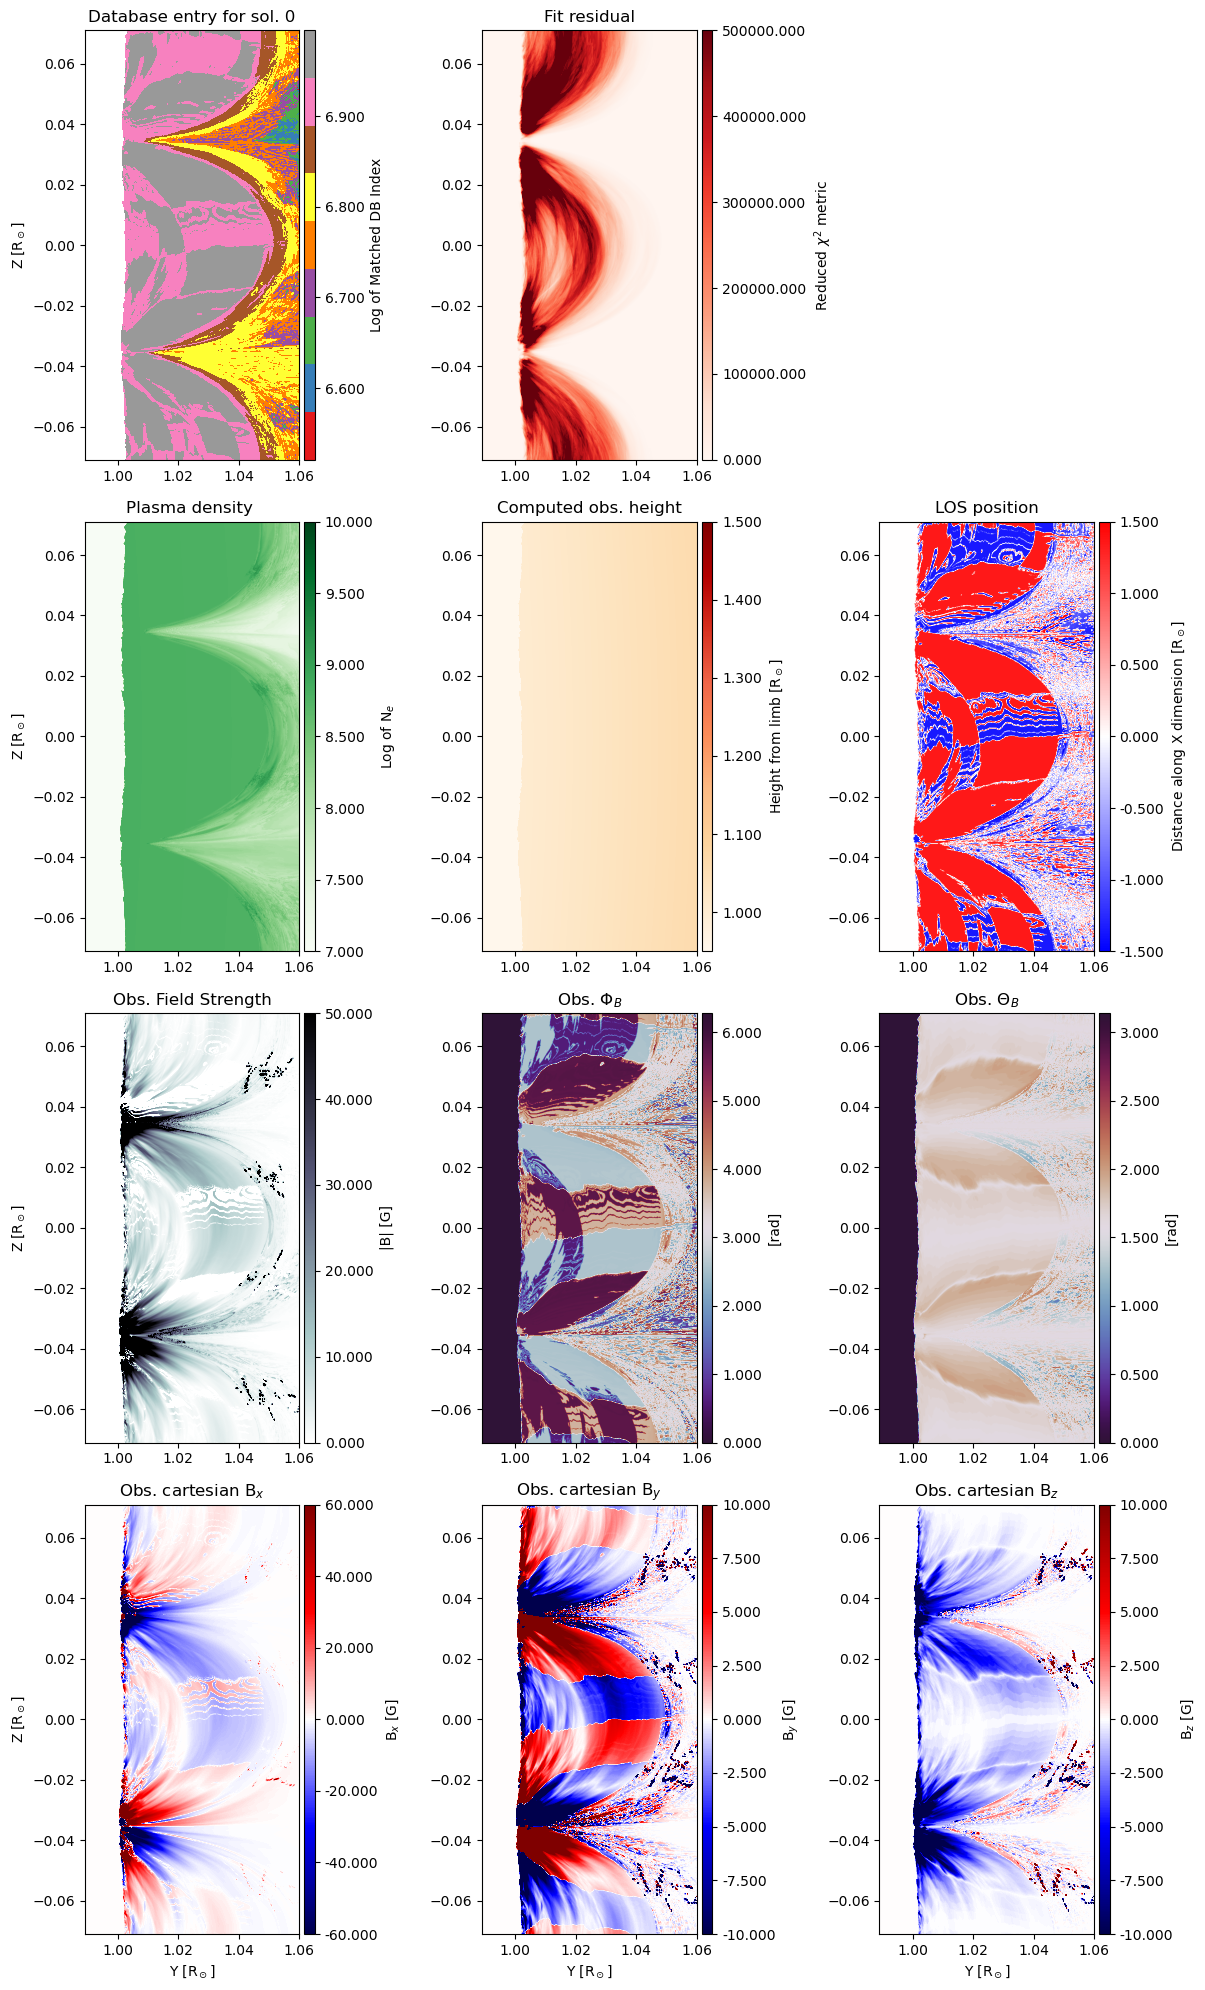

In [21]:
## Plot magnetic inversion

soln=0   ## selects the solution to plot < nsearch

fig, plots = plt.subplots(nrows=4, ncols=3, figsize=(12,20))

ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')
plots[0,0].set_title(f'Database entry for sol. {soln}')
colorbar(ab, title='Log of Matched DB Index')
plots[0,0].set_ylabel('Z [R$_\odot$]')

ab=plots[0,1].imshow(invout[srx1:srx2,sry1:sry2,soln,1],extent=rnge,cmap='Reds',vmin=0,vmax=500000)
plots[0,1].set_title('Fit residual')
colorbar(ab, title='Reduced $\chi^2$ metric')

plots[0, 2].axis('off') ###leave one empty panel

ab=plots[1,0].imshow(invout[srx1:srx2,sry1:sry2,soln,2],cmap='Greens',extent=rnge,vmin=7,vmax=10)
plots[1,0].set_title('Plasma density ')
colorbar(ab, title='Log of N$_e$')
plots[1,0].set_ylabel('Z [R$_\odot$]')

ab=plots[1,1].imshow(invout[srx1:srx2,sry1:sry2,soln,3],extent=rnge,cmap='OrRd',vmin=0.95,vmax=1.5)
plots[1,1].set_title('Computed obs. height')
colorbar(ab, title='Height from limb [R$_\odot$]')

ab=plots[1,2].imshow(invout[srx1:srx2,sry1:sry2,soln,4],extent=rnge,cmap='bwr',vmin=-1.5,vmax=1.5)
plots[1,2].set_title('LOS position')
colorbar(ab, title='Distance along X dimension [R$_\odot$]')


ab=plots[2,0].imshow(invout[srx1:srx2,sry1:sry2,soln,5],extent=rnge,cmap='bone_r',vmin=0,vmax=50)
plots[2,0].set_title('Obs. Field Strength')
colorbar(ab, title='|B| [G]')
plots[2,0].set_ylabel('Z [R$_\odot$]')

ab=plots[2,1].imshow(invout[srx1:srx2,sry1:sry2,soln,6],extent=rnge,vmin=0,vmax=6.28,cmap='twilight_shifted')
plots[2,1].set_title('Obs. $\Phi_B$')
colorbar(ab, title='[rad]')

ab=plots[2,2].imshow(invout[srx1:srx2,sry1:sry2,soln,7],extent=rnge,vmin=0,vmax=3.14,cmap='twilight_shifted')
plots[2,2].set_title('Obs. $\Theta_B$')
colorbar(ab, title='[rad]')


ab=plots[3,0].imshow(invout[srx1:srx2,sry1:sry2,soln,8],extent=rnge,cmap='seismic',vmin=-60,vmax=60)
plots[3,0].set_title('Obs. cartesian B$_x$')
colorbar(ab, title='B$_x$ [G]')
plots[3,0].set_ylabel('Z [R$_\odot$]')
plots[3,0].set_xlabel('Y [R$_\odot$]')

ab=plots[3,1].imshow(invout[srx1:srx2,sry1:sry2,soln,9],extent=rnge,cmap='seismic',vmin=-10,vmax=10)
plots[3,1].set_title('Obs. cartesian B$_y$')
colorbar(ab, title='B$_y$ [G]')
plots[3,1].set_xlabel('Y [R$_\odot$]')

ab=plots[3,2].imshow(invout[srx1:srx2,sry1:sry2,soln,10],extent=rnge,cmap='seismic',vmin=-10,vmax=10)
plots[3,2].set_title('Obs. cartesian B$_z$')
colorbar(ab, title='B$_z$ [G]')
plots[3,2].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/invout_2line__sol{soln}_{datestamp}.pdf")

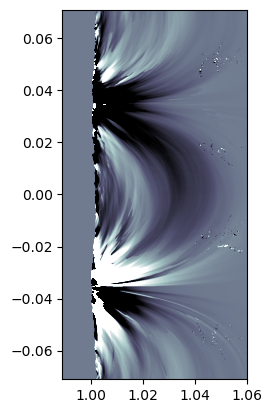

In [24]:
plt.figure()
plt.imshow(invout[srx1:srx2,sry1:sry2,1,5]*np.cos(invout[srx1:srx2,sry1:sry2,1,6]),extent=rnge,cmap='bone',vmin=-15,vmax=15)

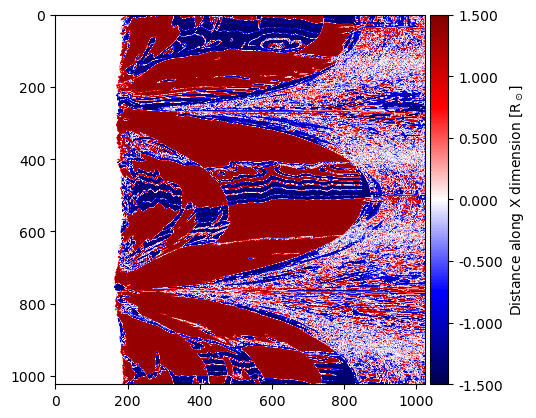

In [25]:
plt.figure()
ab=plt.imshow(invout[:,:,0,4],cmap='seismic',vmin=-1.5,vmax=1.5)
colorbar(ab, title='Distance along X dimension [R$_\odot$]')

In [118]:
##Print inversion solution in a human readable way

np.set_printoptions(linewidth=200,suppress=False)   ## Suppress can be set to true to disable exponential notation.
xx=391      ## x pixel position
yy=675      ## y pixel positions


print("||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||")
print(invout[xx,yy,:,:])


||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||
[[ 7.9638740e+06  1.7352338e+04  8.7823381e+00  1.0356483e+00 -1.3500000e+00  9.0492220e+00  3.7558703e+00  1.5531471e+00 -7.3937821e+00 -5.2148733e+00  1.5970369e-01]
 [ 8.8356160e+06  1.7352338e+04  8.7823381e+00  1.0356483e+00  1.3500000e+00  9.0492210e+00  2.5624163e+00  1.6237447e+00 -7.5628042e+00  4.9460125e+00 -4.7891790e-01]
 [ 7.9638730e+06  1.7353381e+04  8.7823381e+00  1.0356483e+00 -1.3500000e+00  9.0659456e+00  3.7558703e+00  1.5178483e+00 -7.3982172e+00 -5.2180014e+00  4.7980011e-01]
 [ 8.8356170e+06  1.7353381e+04  8.7823381e+00  1.0356483e+00  1.3500000e+00  9.0659456e+00  2.5624163e+00  1.6590434e+00 -7.5578904e+00  4.9427986e+00 -7.9900545e-01]]
